In [27]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_hub as hub
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


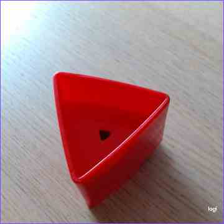

In [4]:
test_image = 'figures/val/triangle/2021-04-15_15-59-40.jpg'
triangle = Image.open(test_image).resize(IMAGE_SHAPE)
triangle

In [5]:
triangle = np.array(triangle)/255.0
triangle.shape

(224, 224, 3)

In [6]:
result = classifier.predict(triangle[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

845

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


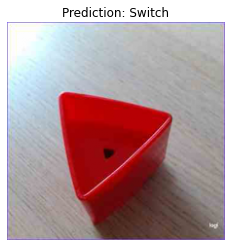

In [9]:
plt.imshow(triangle)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [10]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str('figures/train'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17 files belonging to 2 classes.
Using 14 files for training.


In [11]:
class_names = np.array(train_ds.class_names)
print(class_names)

['square' 'triangle']


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [15]:
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(14, 224, 224, 3)
(14,)


In [17]:
result_batch = classifier.predict(train_ds)

In [18]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pencil sharpener', 'pencil sharpener', 'pencil sharpener',
       'switch', 'pencil sharpener', 'pick', 'binder', 'switch',
       'pencil sharpener', 'pencil sharpener', 'pencil sharpener',
       'pencil sharpener', 'pencil sharpener', 'bucket'], dtype='<U30')

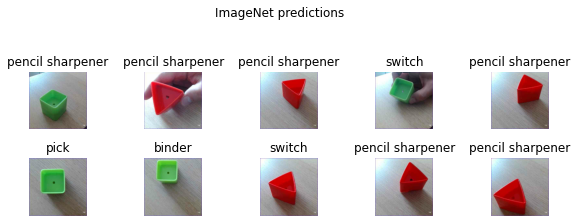

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [20]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(14, 1280)


In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([14, 2])

In [30]:
# Data Augmentation
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_width, img_height),
  layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [31]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [33]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(aug_ds, epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
1/1 [==============================] - 0s 1000us/step - loss: 0.7106 - acc: 0.5714
Epoch 2/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6929 - acc: 0.5714
Epoch 3/20
1/1 [==============================] - 0s 2ms/step - loss: 0.7049 - acc: 0.4286
Epoch 4/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6913 - acc: 0.5714
Epoch 5/20
1/1 [==============================] - 0s 1ms/step - loss: 0.6859 - acc: 0.5714
Epoch 6/20
1/1 [==============================] - 0s 999us/step - loss: 0.6929 - acc: 0.5714
Epoch 7/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6948 - acc: 0.5714
Epoch 8/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6891 - acc: 0.5714
Epoch 9/20
1/1 [==============================] - 0s 1ms/step - loss: 0.6847 - acc: 0.5714
Epoch 10/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6865 - acc: 0.5714
Epoch 11/20
1/1 [==============================] - 0s 2ms/step - loss: 0.6897 - acc:

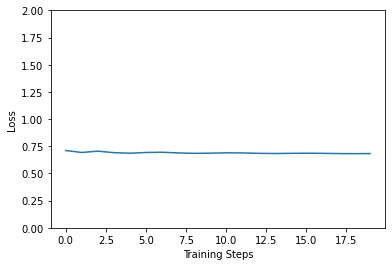

In [34]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

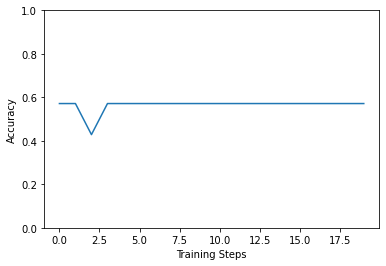

In [35]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

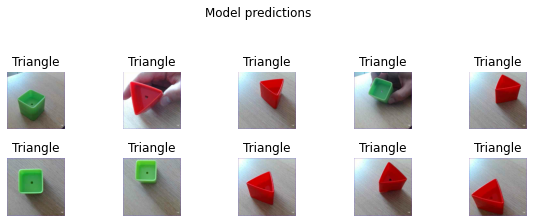

In [36]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

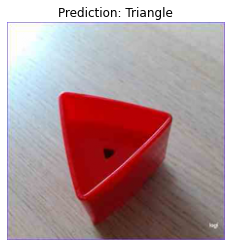

In [41]:
result = model.predict(triangle[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label = class_names[predicted_id]
result.shape
plt.imshow(triangle)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_label[0].title())

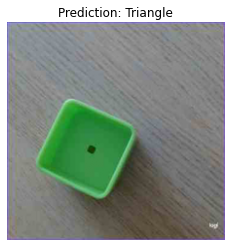

In [46]:
test_image = 'figures/train/square/2021-04-15_15-52-12.jpg'
square = Image.open(test_image).resize(IMAGE_SHAPE)
square = np.array(square)/255.0
result = model.predict(square[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label = class_names[predicted_id]
result.shape
plt.imshow(square)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_label[0].title())

In [42]:
model.save_weights("weights.h5")
model.load_weights("weights.h5")